# IE423: Quality Engineering Project

### Group Members
* Berat Kubilay Güngez - 2021402087
* Ömer Faruk Tunçay - 2019405018

table of conents olsun bence, benim 582 ödevinden copy paste yaptım editlersiniz

### Table of Contents

1. [Introduction](#introduction)
2. [Library and Data Imports](#import)
3. [Implied Probability Calculation and Analysis](#prob)
4. [Noisy Data Analysis](#noisy)
5. [Decision Tree Model](#tree)
6. [Conclusion](#conclusion)
7. [Code](#code)

### Introduction <a name="introduction"></a>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import numpy as np # math operations

In [2]:
data_loc = "/content/matches"
df = pd.read_csv(data_loc)

df.tail(5) # Show the last 5 rows of the data

,fixture_id,name,halftime,minute,Successful.Passes_home,Successful.Passes_away,Ball.Possession_home,Ball.Possession_away,Goals_home,Goals_away,Attacks_home,Attacks_away,Yellowcards_home,Yellowcards_away,Redcards_home,Redcards_away,Penalties_home,Penalties_away
9858,19135371,Getafe vs Girona,2nd-half,94,307,369,47,53,0,1,117,60,2,3,0,0,0,0
9859,19135371,Getafe vs Girona,2nd-half,95,309,375,47,53,0,1,118,61,2,3,0,0,0,0
9860,19135371,Getafe vs Girona,2nd-half,96,309,376,47,53,0,1,118,62,3,3,0,0,0,0
9861,19135371,Getafe vs Girona,2nd-half,97,309,376,47,53,0,1,119,62,3,3,0,0,0,0
9862,19135371,Getafe vs Girona,2nd-half,98,311,382,47,53,0,1,119,62,3,3,0,0,0,0


In [3]:
columns_to_drop = ["Successful.Passes_home", "Successful.Passes_away", "Ball.Possession_home", "Ball.Possession_away", "Attacks_away", "halftime"] # We are not interested in these columns
df.drop(columns=columns_to_drop, inplace=True) # Drop the columns

lst = df.columns.tolist() # Get the columns of the data
to_remove = ["fixture_id", "name", "halftime", "minute"] # Columns that we do not want to calculate differencing
lst = [col for col in lst if col not in to_remove] # Remove the columns that we do not want to apply differencing
for col in lst:
    df[col] = df.groupby("fixture_id")[col].diff().fillna(df[col]) # Apply differencing to the columns

df.tail(5) # Show the last 5 rows of the data

,fixture_id,name,minute,Goals_home,Goals_away,Attacks_home,Yellowcards_home,Yellowcards_away,Redcards_home,Redcards_away,Penalties_home,Penalties_away
9858,19135371,Getafe vs Girona,94,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
9859,19135371,Getafe vs Girona,95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9860,19135371,Getafe vs Girona,96,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9861,19135371,Getafe vs Girona,97,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9862,19135371,Getafe vs Girona,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
unusual_matches = []
out_of_control_min = []

event_counts = {"Redcards_home": 0, "Redcards_away": 0,
                "Yellowcards_home": 0, "Yellowcards_away": 0,
                "Goals_home": 0, "Goals_away": 0,
                "Penalties_home": 0, "Penalties_away": 0}

event_columns = ["Redcards_home", "Redcards_away",
    "Yellowcards_home", "Yellowcards_away",
    "Goals_home", "Goals_away",
    "Penalties_home", "Penalties_away"]

variable_of_interest = "Attacks_home"
mean = df[variable_of_interest].mean()
std = df[variable_of_interest].std(ddof=1)

k = 0.5 # Allowance parameter
h = 5  # Decision interval parameter

ucl = h * std # Upper Control Limit
lcl = -h * std # Lower Control Limit

K = k * std # Allowance

for id in df["fixture_id"].unique():
    mask = df["fixture_id"] == id
    match_specific_data = df[mask][variable_of_interest]

    cusum_positive = [0] # Initialize the positive CUSUM
    cusum_negative = [0] # Initialize the negative CUSUM
    out_of_control_minutes = []

    for minute,x in enumerate(match_specific_data):
        cp = max(0, cusum_positive[-1] + x - (mean + K))
        cn = max(0, cusum_negative[-1] + (mean - K) - x)
        cusum_positive.append(cp)
        cusum_negative.append(-cn)

        if cp > ucl or cn < lcl:
            out_of_control_minutes.append(minute)

    cusum_positive = cusum_positive[1:] # Remove the first element
    cusum_negative = cusum_negative[1:] # Remove the first element

    # Check if the match is unusual
    if max(cusum_positive) > ucl or min(cusum_negative) < lcl: # If the maximum positive CUSUM is greater than the UCL or the minimum negative CUSUM is less than the LCL
        unusual_matches.append(id)
        out_of_control_min.append((id, out_of_control_minutes))  # Store the match_id and the out-of-control minutes

        for column in event_columns:
            if df[mask][column].sum() > 0:
                event_counts[column] += 1

print(f"Total unusual matches: {len(unusual_matches)}")
print("\n")

for key, value in event_counts.items():
    print(f"Total {key}: {value}")
    print("------------------------------------------------")

print("\n")
for match_id, minutes in out_of_control_min:
    print(f"Match {match_id}: Out of control at minutes {minutes}")

Total unusual matches: 35


Total Redcards_home: 0
------------------------------------------------
Total Redcards_away: 4
------------------------------------------------
Total Yellowcards_home: 26
------------------------------------------------
Total Yellowcards_away: 29
------------------------------------------------
Total Goals_home: 24
------------------------------------------------
Total Goals_away: 20
------------------------------------------------
Total Penalties_home: 4
------------------------------------------------
Total Penalties_away: 4
------------------------------------------------


Match 19135258: Out of control at minutes [5]
Match 19139654: Out of control at minutes [79, 80, 81, 82]
Match 19155073: Out of control at minutes [10, 14, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 51, 60]
Match 19172022: Out of control at minutes [21, 43, 44, 45, 68]
Match 19134467: Out of control at minutes [22, 23, 24, 25, 26, 27, 28, 29, 30

In [5]:
def plot_cusum_chart(fixture_id, events = None, k=0.5, h=5):

    # Get the data
    statistics = df[variable_of_interest]
    mean = statistics.mean()
    std = statistics.std(ddof=1)

    # Calculate limits and allowance
    ucl = h * std  # Upper Control Limit
    lcl = -h * std  # Lower Control Limit
    K = k * std  # Allowance

    # Filter data for the specific match
    mask = df["fixture_id"] == fixture_id
    match_name = df[mask]["name"].values[0]
    max_minute = df[mask]["minute"].max()
    match_specific_data = df[mask][variable_of_interest]

    # CUSUM Algorithm
    cusum_positive = [0]  # Initialize the positive CUSUM
    cusum_negative = [0]  # Initialize the negative CUSUM

    for x in match_specific_data:
        cp = max(0, cusum_positive[-1] + x - (mean + K))
        cn = max(0, cusum_negative[-1] + (mean - K) - x)
        cusum_positive.append(cp)
        cusum_negative.append(-cn)

    cusum_positive = cusum_positive[1:]  # Remove the first element
    cusum_negative = cusum_negative[1:]  # Remove the first element

    # Plot the CUSUM Chart
    plt.figure(figsize=(12, 6))
    plt.plot(cusum_positive, marker='o', color="blue", label="Positive CUSUM")
    plt.plot(cusum_negative, marker='o', color="green", label="Negative CUSUM")

    plt.axhline(ucl, color="red", linestyle="--")
    plt.text(x=5, y=ucl, s="Upper CUSUM", color="black", ha="center", va="bottom", fontsize=10, fontweight="bold")
    plt.axhline(lcl, color="red", linestyle="--")
    plt.text(x=5, y=lcl, s="Lower CUSUM", color="black", ha="center", va="bottom", fontsize=10, fontweight="bold")

    # Plot Goals, Red Cards, Yellow Cards, Penalties
    event_colors = {
    "Goals_home": "black", "Goals_away": "black",
    "Redcards_home": "red", "Redcards_away": "red",
    "Yellowcards_home": "orange", "Yellowcards_away": "orange",
    "Penalties_home": "blue", "Penalties_away": "blue"}

    event_data = df[df["fixture_id"] == fixture_id]

    for event in events:
        for _, row in event_data.iterrows():
            if row[event] > 0:  # Plot only if the event occurs
                plt.axvline(row["minute"], color=event_colors[event], linestyle="--", alpha=0.7, label=event)

    plt.xlim(0, max_minute)
    plt.title(f"CUSUM Chart of {variable_of_interest} for {match_name}", fontsize=16, fontweight="bold")
    plt.xlabel("Minute", fontsize=12)
    plt.ylabel("Cumulative Sum", fontsize=12)
    plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=10, loc="upper right")
    plt.tight_layout()
    plt.show()


Eğer başka şeyleri de incelemek isterseniz aşağıyı düzenleyebilirsinz, ben bura ile oynayarak ilginç maçları aradan seçtim

In [6]:
"""
events_of_interest = ["Goals_away"]

for match_id in unusual_matches:
    mask = df["fixture_id"] == match_id
    match_df = df[mask]
    for event in events_of_interest:
        if match_df[event].sum() > 0:
            print(f"Match ID: {match_id}")
            plot_cusum_chart(match_id, events=events_of_interest)
"""

'\nevents_of_interest = ["Goals_away"]\n\nfor match_id in unusual_matches:\n    mask = df["fixture_id"] == match_id\n    match_df = df[mask]\n    for event in events_of_interest:\n        if match_df[event].sum() > 0:\n            print(f"Match ID: {match_id}")\n            plot_cusum_chart(match_id, events=events_of_interest)\n'

In [7]:
event = ["Goals_away"]

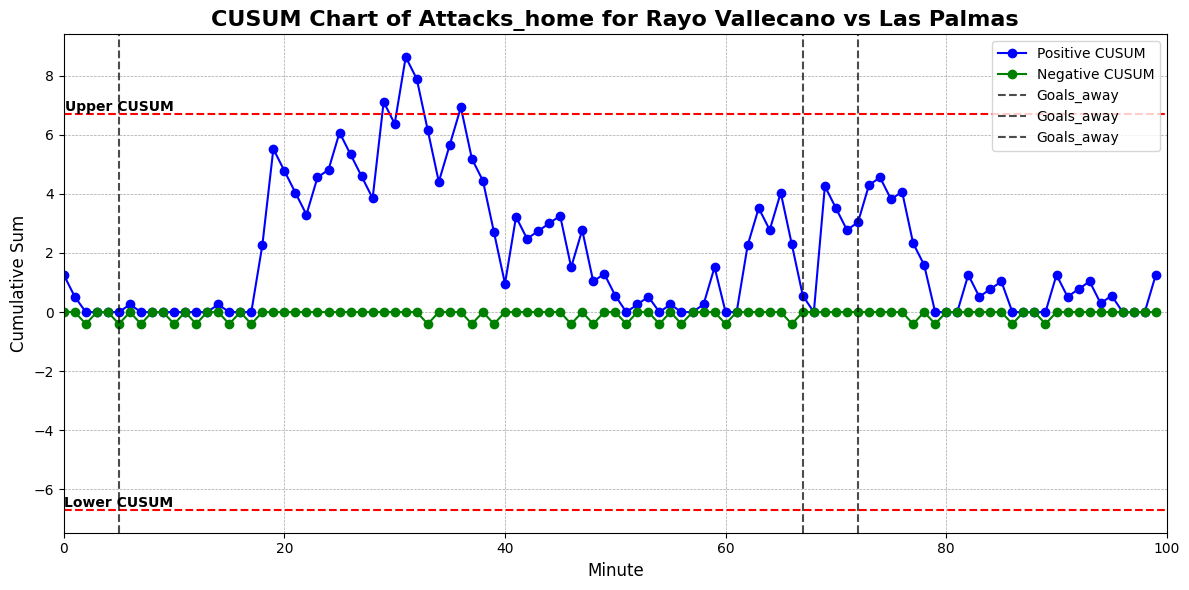

In [8]:
plot_cusum_chart(19135378, events=event)

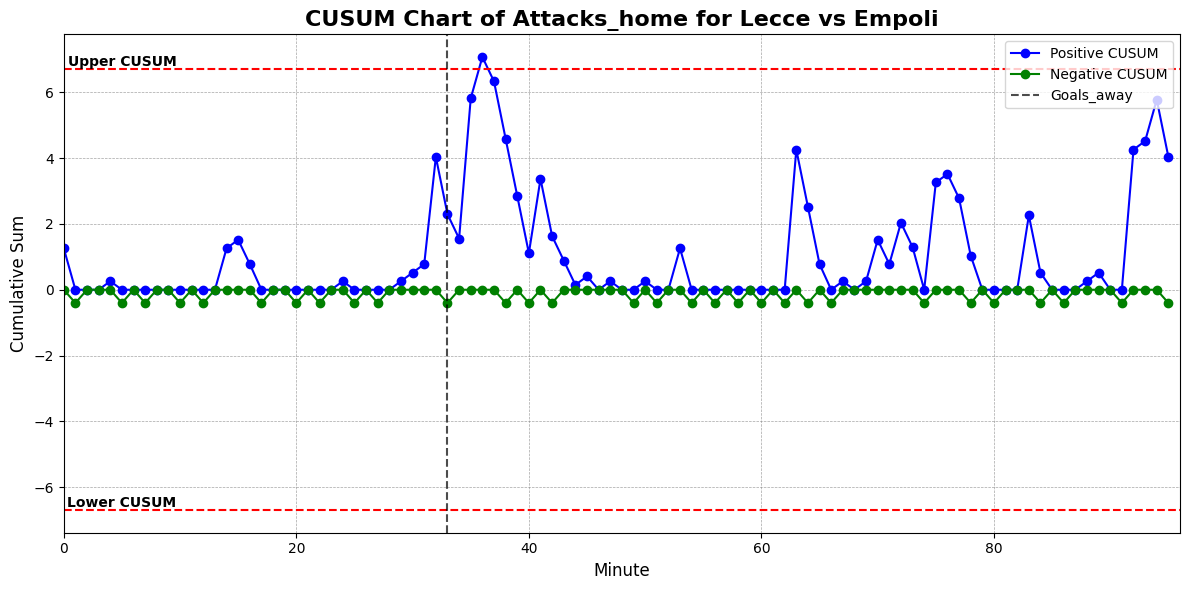

In [9]:
plot_cusum_chart(19155183, events=event)

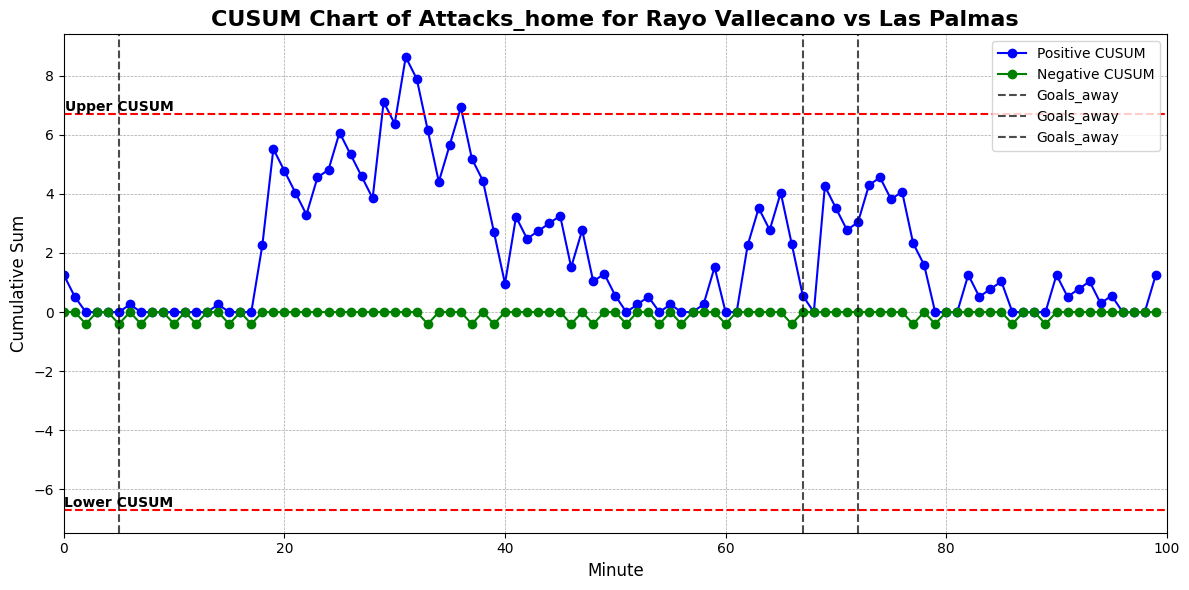

In [10]:
plot_cusum_chart(19135378, events=event)

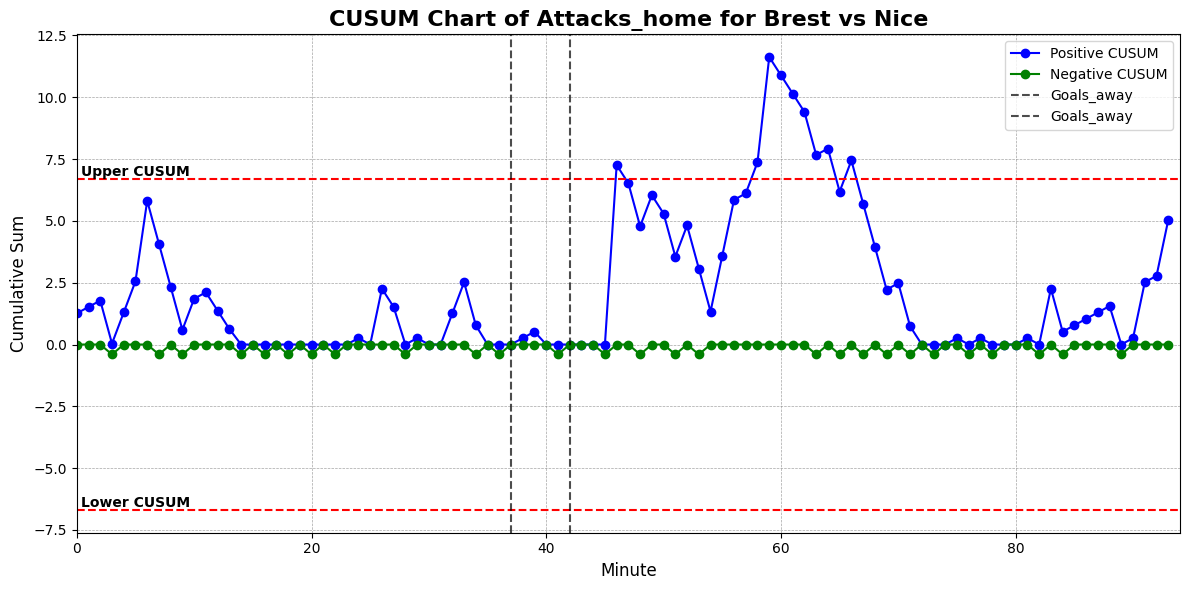

In [11]:
plot_cusum_chart(19139740, events=event)

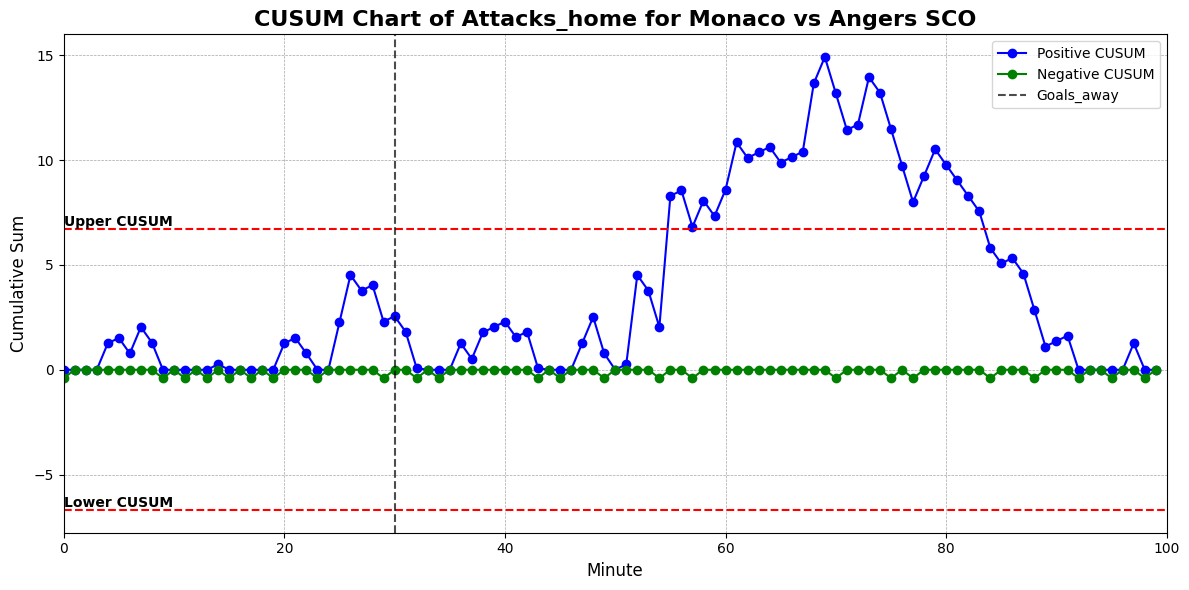

In [12]:
plot_cusum_chart(19139735, events=event)

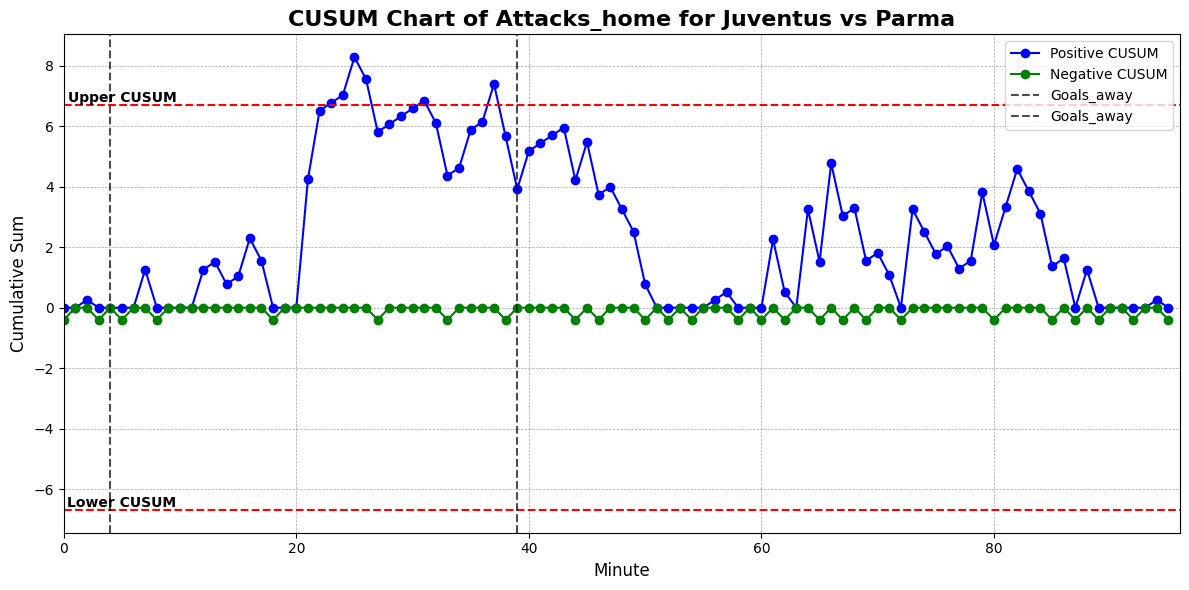

In [13]:
plot_cusum_chart(19155162, events=event)

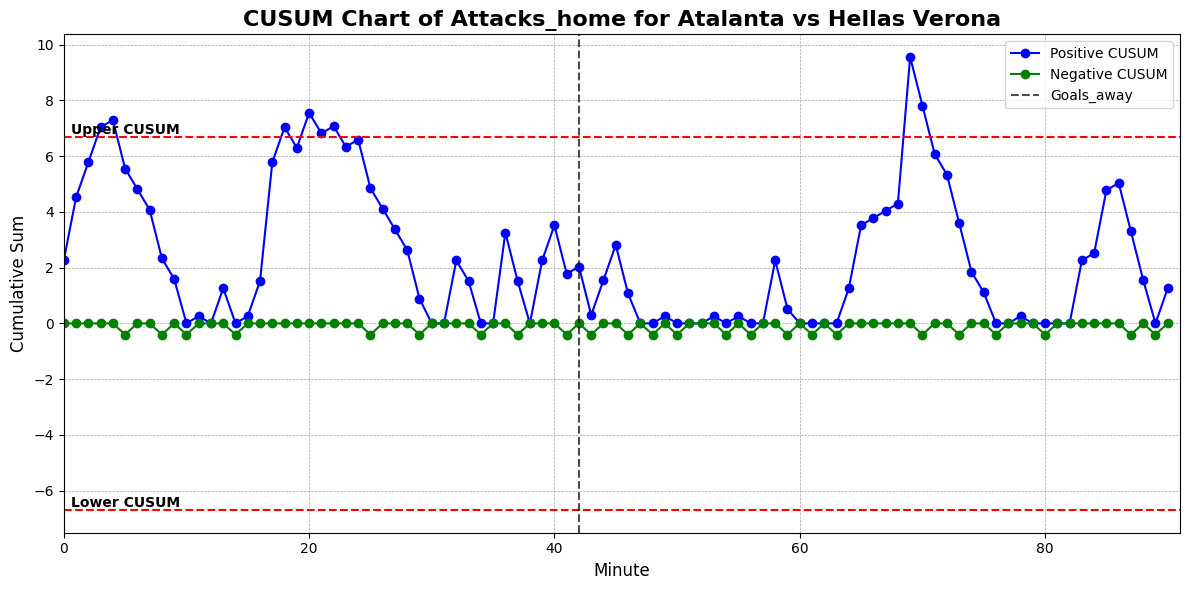

In [14]:
plot_cusum_chart(19155147, events=event)

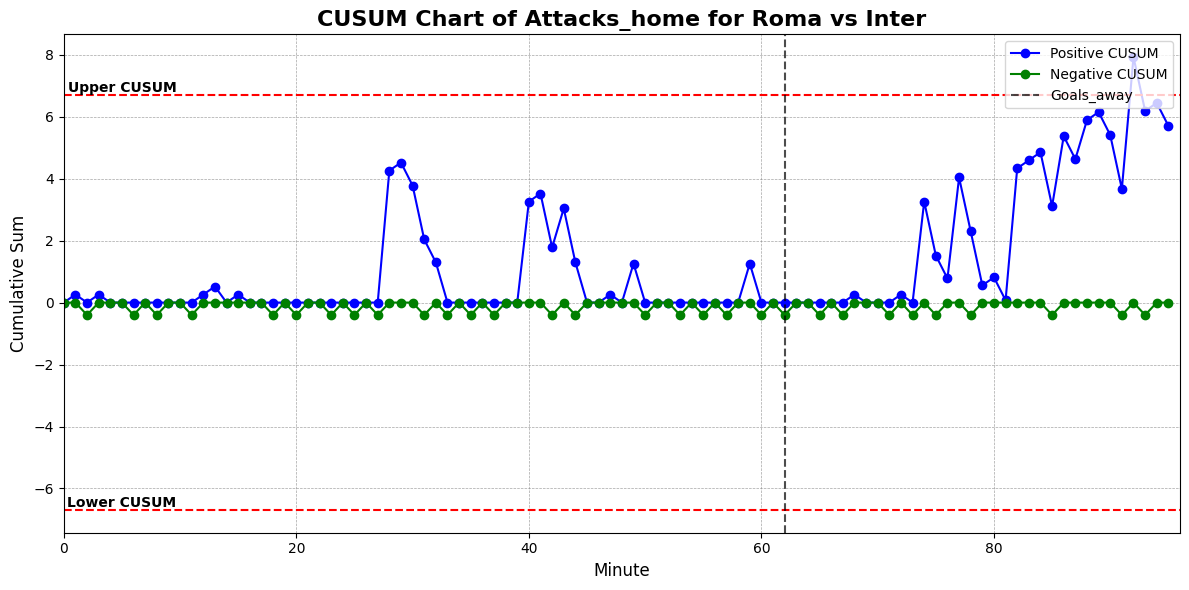

In [15]:
plot_cusum_chart(19155145, events=event)

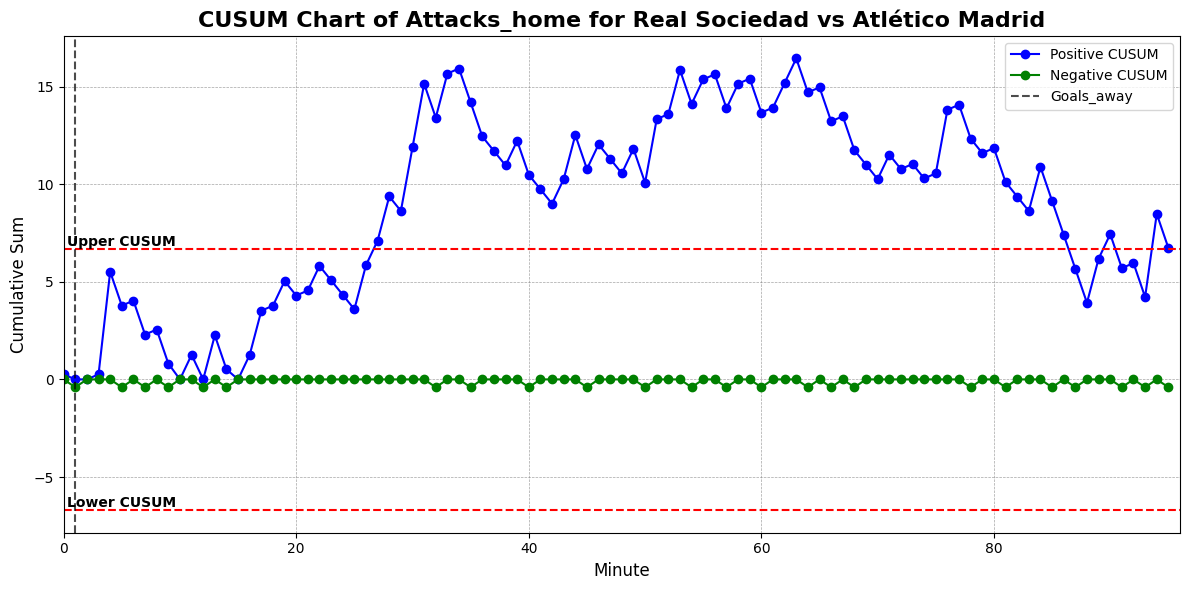

In [16]:
plot_cusum_chart(19135336, events=event)

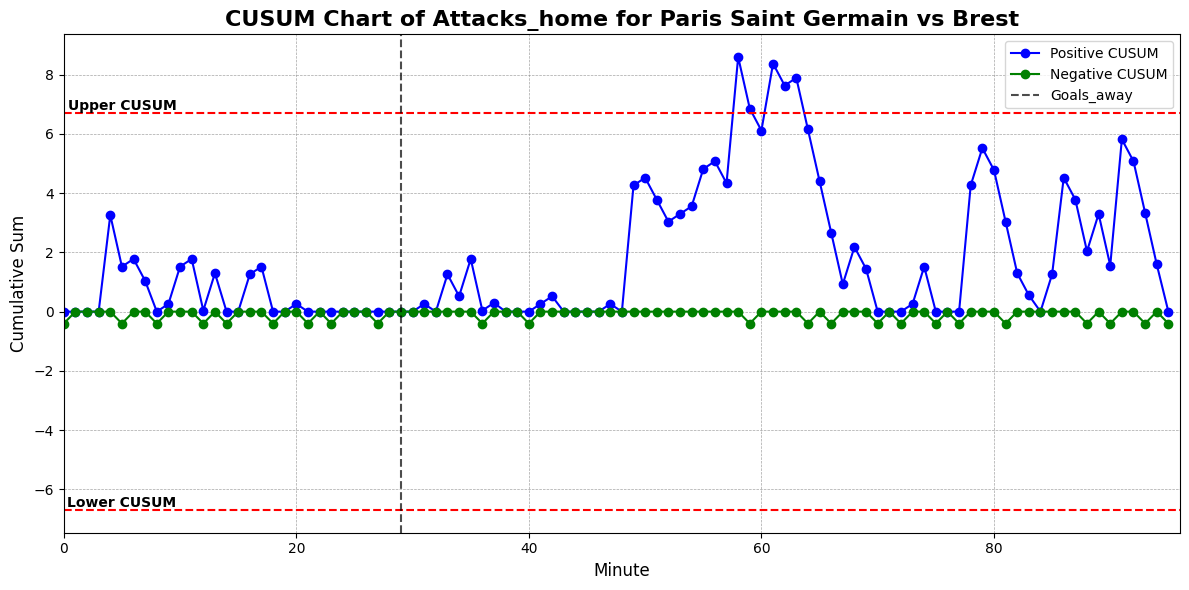

In [17]:
plot_cusum_chart(19139687, events=event)

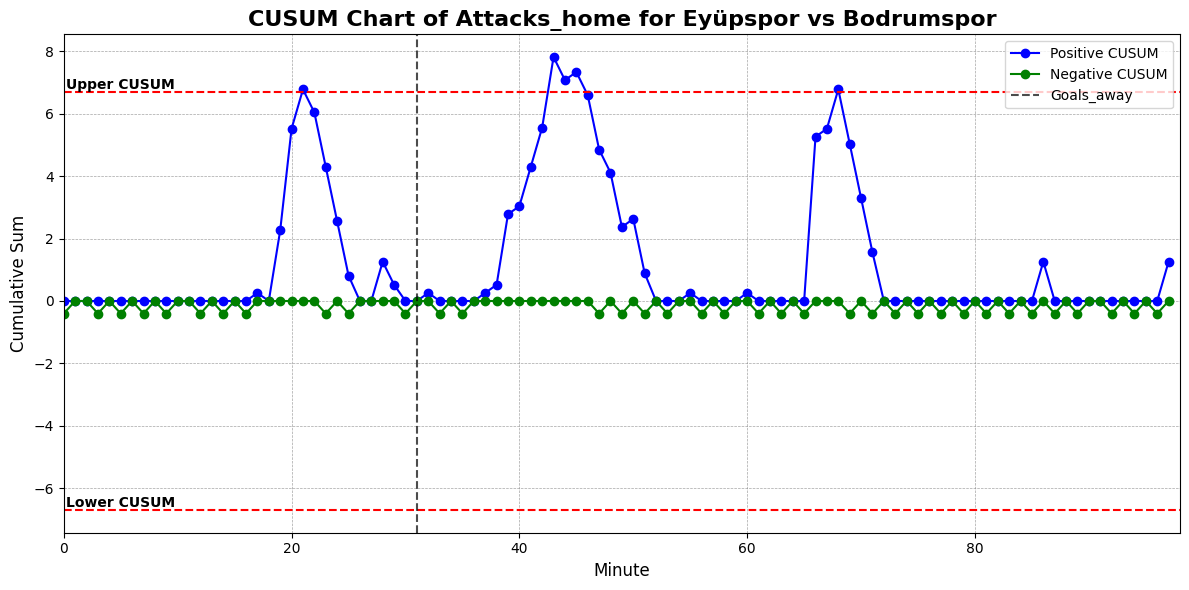

In [18]:
plot_cusum_chart(19172022, events=event)

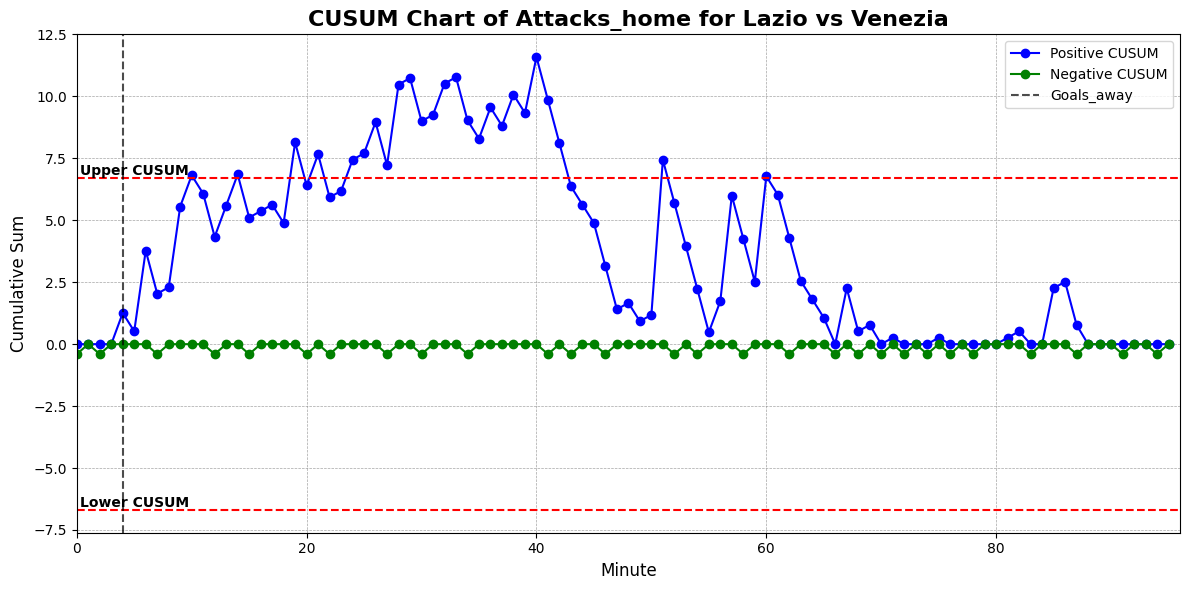

In [19]:
plot_cusum_chart(19155073, events=event)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
data_loc = "/content/matches"
df = pd.read_csv(data_loc)

# Drop columns we are not interested in
columns_to_drop = [
    "Successful.Passes_home", "Successful.Passes_away",
    "Ball.Possession_home", "Ball.Possession_away",
    "Attacks_away", "halftime"
]
df.drop(columns=columns_to_drop, inplace=True)

# Apply differencing to cumulative statistics
lst = df.columns.tolist()  # Get the columns of the data
to_remove = ["fixture_id", "name", "halftime", "minute"]  # Columns to exclude from differencing
lst = [col for col in lst if col not in to_remove]  # Columns to apply differencing to
for col in lst:
    df[col] = df.groupby("fixture_id")[col].diff().fillna(df[col])  # Apply differencing

# Define the events to monitor
event_columns = [
    "Redcards_home", "Redcards_away",
    #"Yellowcards_home", "Yellowcards_away",
    "Goals_home", "Goals_away",
    #"Penalties_home", "Penalties_away"
]

variable_of_interest = "Attacks_home"  # The metric we're analyzing

# Initialize lists to store warnings and corresponding events
warnings_list = []
events_after_warnings = []

# Iterate over each unique match
for match_id in df["fixture_id"].unique():
    match_data = df[df["fixture_id"] == match_id].reset_index(drop=True)
    match_name = match_data["name"].iloc[0]
    max_minute = match_data["minute"].max()
    warnings_in_match = []

    # Initialize CUSUM statistics
    cusum_positive = [0]  # Positive CUSUM
    cusum_negative = [0]  # Negative CUSUM

    # Loop over each minute in the match
    for t in range(1, int(max_minute) + 1):
        # Data up to time t-1
        data_up_to_t_minus_1 = match_data[match_data["minute"] < t]
        if data_up_to_t_minus_1.empty:
            continue  # Skip if no data available

        # Compute mean and std based on data up to t-1
        current_data = data_up_to_t_minus_1[variable_of_interest]
        mean = current_data.mean()
        std = current_data.std(ddof=1)
        if std == 0 or np.isnan(std):
            std = 1e-6  # To avoid division by zero

        # CUSUM parameters
        k = 0.5 * std          # Allowance parameter
        h = 5 * std            # Decision interval parameter
        K = k                  # K is the allowance
        ucl = h                # Upper Control Limit
        lcl = -h               # Lower Control Limit

        # Get the metric value at time t
        x_t = match_data[match_data["minute"] == t][variable_of_interest].values[0]

        # Update CUSUM statistics
        cp = max(0, cusum_positive[-1] + x_t - (mean + K))
        cn = max(0, cusum_negative[-1] + (mean - K) - x_t)
        cusum_positive.append(cp)
        cusum_negative.append(-cn)

        # Check for out-of-control condition (warning sign)
        if cp > ucl or cn < lcl:
            warnings_in_match.append(t)  # Record the warning time

            # Check for significant events after the warning
            event_found = False
            for event in event_columns:
                # Look for events occurring after the warning time
                event_data = match_data[
                    (match_data["minute"] > t) &
                    (match_data[event] > 0)
                ]
                if not event_data.empty:
                    event_minute = event_data.iloc[0]["minute"]
                    time_diff = event_minute - t
                    events_after_warnings.append({
                        "match_id": match_id,
                        "match_name": match_name,
                        "warning_time": t,
                        "event_time": event_minute,
                        "time_difference": time_diff,
                        "event_type": event
                    })
                    event_found = True
                    break  # Stop after finding the first event
            if not event_found:
                # No event found after this warning
                events_after_warnings.append({
                    "match_id": match_id,
                    "match_name": match_name,
                    "warning_time": t,
                    "event_time": None,
                    "time_difference": None,
                    "event_type": None
                })

    # Store the warnings for the match
    warnings_list.extend([{
        "match_id": match_id,
        "match_name": match_name,
        "warning_time": w_time
    } for w_time in warnings_in_match])

# Create DataFrames from the warnings and events
warnings_df = pd.DataFrame(warnings_list)
events_df = pd.DataFrame(events_after_warnings)

# Display the warnings and events
print("Warnings Detected:")
print(warnings_df)
print("\nEvents After Warnings:")
print(events_df)

# Compute statistics about time differences between warnings and events
valid_events = events_df[events_df["event_time"].notnull()]
if not valid_events.empty:
    avg_time_difference = valid_events["time_difference"].mean()
    print(f"\nAverage time difference between warning sign and event: {avg_time_difference:.2f} minutes")
else:
    print("\nNo events occurring after warnings were detected in the dataset.")

# Analyze whether warnings can anticipate significant events
total_warnings = len(warnings_df)
warnings_followed_by_events = valid_events.shape[0]
if total_warnings > 0:
    reliability = (warnings_followed_by_events / total_warnings) * 100
    print(f"Percentage of warnings followed by events: {reliability:.2f}%")
else:
    print("No warnings were detected in the dataset.")

Warnings Detected:
     match_id                       match_name  warning_time
0    19134453      Manchester United vs Fulham             3
1    19134453      Manchester United vs Fulham            22
2    19134453      Manchester United vs Fulham            23
3    19134453      Manchester United vs Fulham            24
4    19134453      Manchester United vs Fulham            33
..        ...                              ...           ...
278  19155178                Cagliari vs Milan            20
279  19155178                Cagliari vs Milan            85
280  19172111  İstanbul Başakşehir vs Beşiktaş             2
281  19172111  İstanbul Başakşehir vs Beşiktaş            34
282  19135371                 Getafe vs Girona             3

[283 rows x 3 columns]

Events After Warnings:
     match_id                       match_name  warning_time  event_time  \
0    19134453      Manchester United vs Fulham             3        88.0   
1    19134453      Manchester United vs Fulham   

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
data_loc = "/content/matches"  # Make sure the correct path and extension are used
df = pd.read_csv(data_loc)

# Drop columns we are not interested in
columns_to_drop = [
    "Successful.Passes_home", "Successful.Passes_away",
    "Ball.Possession_home", "Ball.Possession_away",
    "Attacks_away", "halftime"
]
df.drop(columns=columns_to_drop, inplace=True)

# Apply differencing to cumulative statistics
lst = df.columns.tolist()  # Get the columns of the data
to_remove = ["fixture_id", "name", "halftime", "minute"]  # Columns to exclude from differencing
lst = [col for col in lst if col not in to_remove]  # Columns to apply differencing to
for col in lst:
    df[col] = df.groupby("fixture_id")[col].diff().fillna(df[col])  # Apply differencing

# Define the events to monitor
event_columns = [
    "Redcards_home", "Redcards_away",
    #"Yellowcards_home", "Yellowcards_away",
    "Goals_home", "Goals_away",
    #"Penalties_home", "Penalties_away"
]

variable_of_interest = "Attacks_home"  # The metric we're analyzing

# Initialize lists to store warnings and corresponding events
warnings_list = []
events_after_warnings = []

# Iterate over each unique match
for match_id in df["fixture_id"].unique():
    match_data = df[df["fixture_id"] == match_id].reset_index(drop=True)
    match_name = match_data["name"].iloc[0]
    max_minute = match_data["minute"].max()
    warnings_in_match = []

    # Initialize CUSUM variables
    cp_last = 0  # Last positive CUSUM value
    cn_last = 0  # Last negative CUSUM value

    # Iterate over each minute starting from minute 31
    for t in range(31, int(max_minute) + 1):  # Start from minute 31 because we need data up to t-1
        # Data up to time t-1, starting from minute 30
        data_up_to_t_minus_1 = match_data[(match_data["minute"] < t) & (match_data["minute"] >= 30)]
        if data_up_to_t_minus_1.empty:
            continue  # Skip if no data available

        # Compute mean and std based on data up to t-1
        current_data = data_up_to_t_minus_1[variable_of_interest]
        mean = current_data.mean()
        std = current_data.std(ddof=1)
        if std == 0 or np.isnan(std):
            std = 1e-6  # To avoid division by zero or NaN

        # CUSUM parameters
        K = 0.5 * std         # Allowance parameter
        h = 5 * std           # Decision interval parameter
        ucl = h               # Upper Control Limit
        lcl = -h              # Lower Control Limit

        # Get the metric value at time t
        x_t_data = match_data[match_data["minute"] == t][variable_of_interest]
        if x_t_data.empty:
            continue  # Skip if no data at time t
        x_t = x_t_data.values[0]

        # Update CUSUM statistics
        cp = max(0, cp_last + x_t - (mean + K))
        cn = min(0, cn_last + x_t - (mean - K))
        cp_last = cp
        cn_last = cn

        # Check for out-of-control condition (warning sign)
        warning_occurred = False
        if cp > ucl:
            warning_occurred = True
        if cn < lcl:
            warning_occurred = True
        if warning_occurred:
            warnings_in_match.append(t)  # Record the warning time
            # Reset CUSUM after a warning to prevent repeated warnings from the same shift
            cp_last = 0
            cn_last = 0

            # Check for significant events after the warning
            event_found = False
            for event in event_columns:
                # Look for events occurring after the warning time
                event_data = match_data[
                    (match_data["minute"] > t) &
                    (match_data[event] > 0)
                ]
                if not event_data.empty:
                    event_minute = event_data.iloc[0]["minute"]
                    time_diff = event_minute - t
                    events_after_warnings.append({
                        "match_id": match_id,
                        "match_name": match_name,
                        "warning_time": t,
                        "event_time": event_minute,
                        "time_difference": time_diff,
                        "event_type": event
                    })
                    event_found = True
                    break  # Stop after finding the first event
            if not event_found:
                # No event found after this warning
                events_after_warnings.append({
                    "match_id": match_id,
                    "match_name": match_name,
                    "warning_time": t,
                    "event_time": None,
                    "time_difference": None,
                    "event_type": None
                })

    # Store the warnings for the match
    warnings_list.extend([{
        "match_id": match_id,
        "match_name": match_name,
        "warning_time": w_time
    } for w_time in warnings_in_match])

# Create DataFrames from the warnings and events
warnings_df = pd.DataFrame(warnings_list)
events_df = pd.DataFrame(events_after_warnings)

# Remove warnings before the 30th minute (if any)
warnings_df = warnings_df[warnings_df['warning_time'] >= 30].reset_index(drop=True)
events_df = events_df[events_df['warning_time'] >= 30].reset_index(drop=True)

# Display the warnings and events
print("Warnings Detected from Minute 30 Onwards:")
print(warnings_df)
print("\nEvents After Warnings from Minute 30 Onwards:")
print(events_df)

# Compute statistics about time differences between warnings and events
valid_events = events_df[events_df["event_time"].notnull()]
if not valid_events.empty:
    avg_time_difference = valid_events["time_difference"].mean()
    print(f"\nAverage time difference between warning sign and event: {avg_time_difference:.2f} minutes")
else:
    print("\nNo events occurring after warnings were detected in the dataset.")


Warnings Detected from Minute 30 Onwards:
     match_id                       match_name  warning_time
0    19134453      Manchester United vs Fulham            31
1    19155076              Parma vs Fiorentina            31
2    19155076              Parma vs Fiorentina            48
3    19135258               Osasuna vs Leganés            31
4    19134460      Brentford vs Crystal Palace            31
..        ...                              ...           ...
153  19135378     Rayo Vallecano vs Las Palmas            31
154  19155178                Cagliari vs Milan            31
155  19134537         Liverpool vs Aston Villa            31
156  19172111  İstanbul Başakşehir vs Beşiktaş            31
157  19135371                 Getafe vs Girona            32

[158 rows x 3 columns]

Events After Warnings from Minute 30 Onwards:
     match_id                       match_name  warning_time  event_time  \
0    19134453      Manchester United vs Fulham            31        88.0   
1  

In [45]:
# Group events_df by 'event_type'
grouped_events = events_df.groupby('event_type')

# Iterate through each event type
for event_type, group in grouped_events:
    # Calculate average time difference for the current event type
    valid_events = group[group["event_time"].notnull()]
    if not valid_events.empty:
        avg_time_diff = valid_events["time_difference"].mean()
        print(f"\nEvent Type: {event_type}")
        print(f"Average time difference: {avg_time_diff:.2f} minutes")

        # Calculate percentage of warnings followed by events for the current event type
        total_warnings_for_type = len(group)
        warnings_followed_by_events_for_type = valid_events.shape[0]

    else:
        print(f"\nEvent Type: {event_type}")
        print("No events occurring after warnings were detected for this event type.")


Event Type: Goals_away
Average time difference: 17.97 minutes

Event Type: Goals_home
Average time difference: 22.78 minutes

Event Type: Redcards_away
Average time difference: 34.31 minutes

Event Type: Redcards_home
Average time difference: 46.33 minutes
